# Trump Tweets Analysis - Topic Modelling - NLP


This project intends to analyse Donald Trump's tweets from July 19th to December 16th 2020. I used Natural language Processing (NLP) methods to clean and analyse the tweets. 

The data were collected from [Kaggel](https://www.kaggle.com/gpreda/trump-tweets).


Here are the steps that I followed:
- Step 1: Read the data
- Step 2: Explore the data
- Step 3: Clean the data
- Step 4: Tokenization
- step 5: Stopwords removal
- step 6: Lemmatization
- step 7: Topic modelling


### Imports - Necessary Library

In [1]:
import re #for regex
import numpy as np # numerical python
import nltk # Natural Language Toolkit
from datetime import datetime,date, timedelta
import seaborn as sns #plots
import pandas as pd #manipulate and create dataframe
from wordcloud import WordCloud #make wordcloud
import matplotlib.pyplot as plt #plot
from nltk.corpus import wordnet #
from collections import Counter #counter
from sklearn.decomposition import NMF
from nltk.corpus import stopwords #list of stopwords
from nltk import word_tokenize, pos_tag #tokenization
from nltk.stem import WordNetLemmatizer #Lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF vectorization
from sklearn.feature_extraction.text import CountVectorizer

### Functions definition

In [2]:
def get_wordnet_pos(word):
    
    """
    Map POS tag to first character (for lemmatization)
    :param word: a word in your dataset
    :return: Part of speech tag
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def get_month_day(date):
    """
    Extract the month and the day in a date
    :param word: a date
    :return: the month and the day
    """
    my_date = datetime.strptime(date, "%Y-%m-%d")
    return my_date.strftime("%b %d")

def GetDaysList(dates):
    """
    Get all days from the first date of the datset to the last date 
    of the dataset
    :param dates: column of the dataset with the dates
    :return: two list: a list with all dates and a epure list for the plots
    """
    
    date_list = []
    for date in dates:
        date_list.append(datetime.strptime(date.split()[0], "%Y-%m-%d"))
    
    max_date = max(date_list)
    min_date = min(date_list)
    delta = max_date - min_date
    
    all_dates = []
    all_dates_epure = []
    skip = 0
    
    for i in range(delta.days + 1):
        day = min_date + timedelta(days=i)
        all_dates.append(day.strftime("%b %d"))
        if i == skip:
            all_dates_epure.append(day.strftime("%b %d"))
            skip += 5
        else:
            all_dates_epure.append("")
    
    
    return all_dates,all_dates_epure


# Step 1: Read the Data

In [3]:
trump_tweets = pd.read_csv("../trump_tweets.xls") #read the data with pandas

# Step 2: Explore the Data

In [4]:
trump_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1285299379746811915,Donald J. Trump,"Washington, DC",45th President of the United States of America🇺🇸,2009-03-18 13:46:38,84262854,50,4,True,2020-07-20 19:43:46,We are United in our effort to defeat the Invi...,NaN,Twitter for iPhone,57356,323246,False
1,1285196013020610562,Donald J. Trump,"Washington, DC",45th President of the United States of America🇺🇸,2009-03-18 13:46:38,84262854,50,4,True,2020-07-20 12:53:01,"Congratulations Allen, great job! https://t.co...",NaN,Twitter for iPhone,20850,107710,False
2,1284899438591451137,Donald J. Trump,"Washington, DC",45th President of the United States of America🇺🇸,2009-03-18 13:46:38,84262854,50,4,True,2020-07-19 17:14:33,"So we catch Obama &amp; Biden, not to even men...",NaN,Twitter for iPhone,74707,300712,False
3,1284894845614600194,Donald J. Trump,"Washington, DC",45th President of the United States of America🇺🇸,2009-03-18 13:46:38,84262854,50,4,True,2020-07-19 16:56:18,"The Radical Left Democrats, who totally contro...",NaN,Twitter for iPhone,39600,160630,False
4,1288503660264058880,Donald J. Trump,"Washington, DC",45th President of the United States of America🇺🇸,2009-03-18 13:46:38,84328108,50,4,True,2020-07-29 15:56:26,I am in @AirForceOne_HQ flying to the Great St...,NaN,Twitter for iPhone,5727,23432,False


In [5]:
trump_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1791 entries, 0 to 1790
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1791 non-null   int64 
 1   user_name         1791 non-null   object
 2   user_location     1791 non-null   object
 3   user_description  1791 non-null   object
 4   user_created      1791 non-null   object
 5   user_followers    1791 non-null   int64 
 6   user_friends      1791 non-null   int64 
 7   user_favourites   1791 non-null   int64 
 8   user_verified     1791 non-null   bool  
 9   date              1791 non-null   object
 10  text              1791 non-null   object
 11  hashtags          68 non-null     object
 12  source            1791 non-null   object
 13  retweets          1791 non-null   int64 
 14  favorites         1791 non-null   int64 
 15  is_retweet        1791 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 199.5+ KB


The dataset contains 1791 tweets (rows) and 16 columns. The tweet are in the column text.

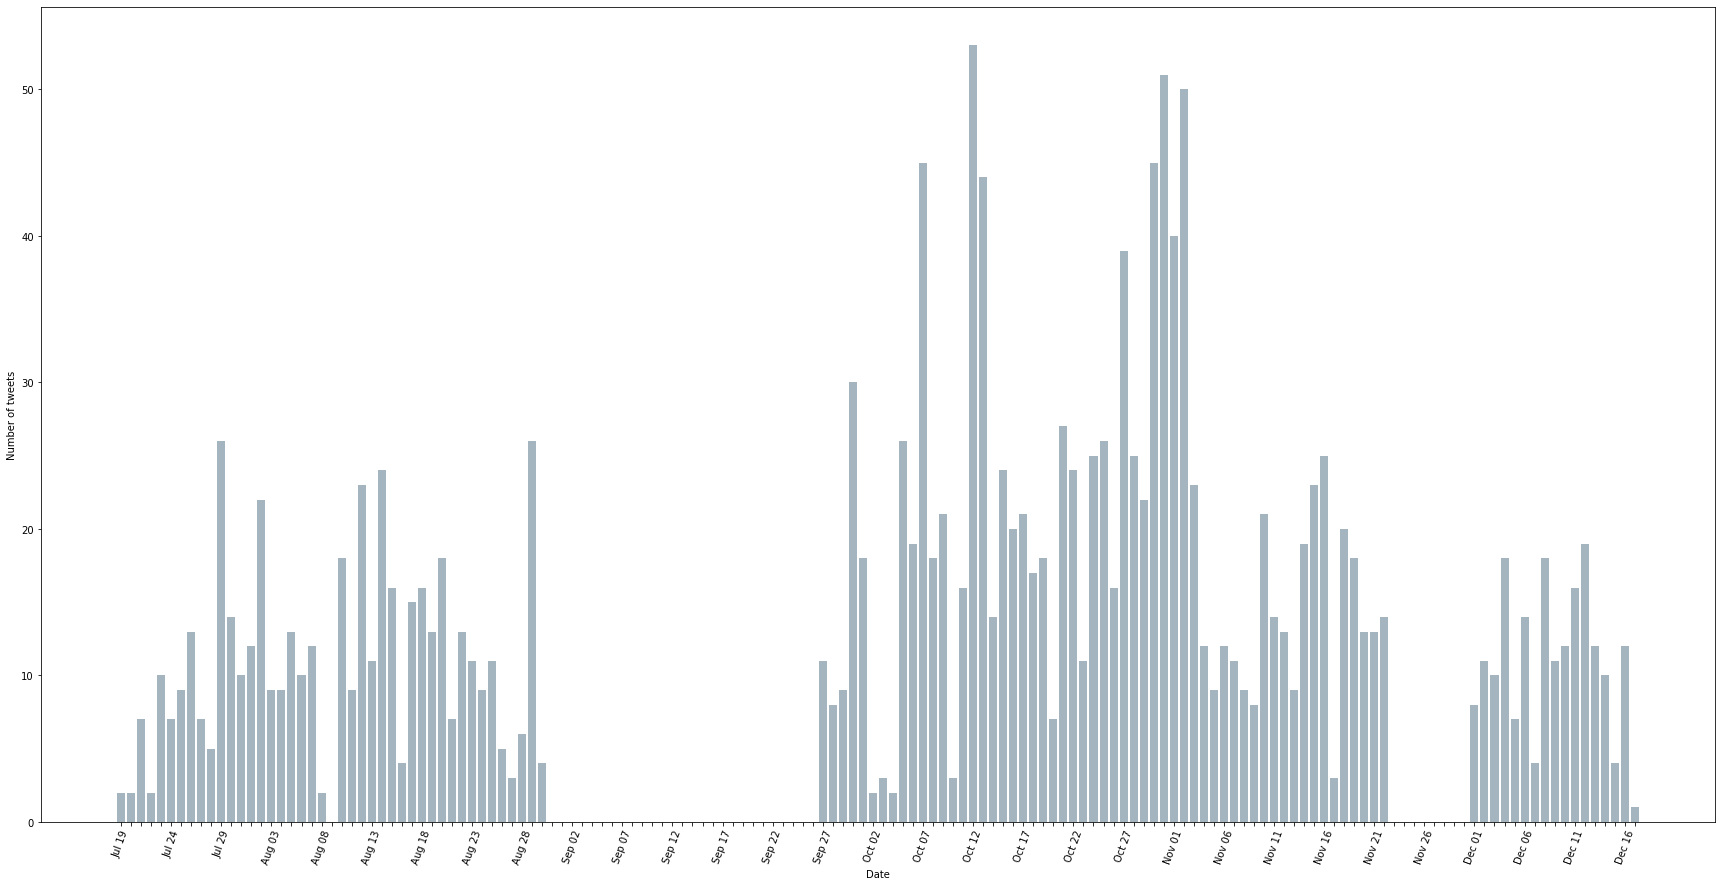

In [6]:
# Let's look at the number of tweet per day

trump_tweets['year_month'] = [get_month_day(date.split()[0]) for date in trump_tweets['date']]
trump_tweets_groupbydate = trump_tweets.groupby(['year_month'])

all_dates,all_dates_epure = GetDaysList(trump_tweets['date'])
all_dates_tweets = []

for date in all_dates:
    if date in trump_tweets_groupbydate.groups.keys():
        all_dates_tweets.append(len(trump_tweets_groupbydate.groups[date]))
    else:
        all_dates_tweets.append(0)
    
plt.subplots(figsize =(30, 15))
plt.rcParams["xtick.labelsize"] = 26
plt.rcParams["ytick.labelsize"] = 26
plt.rcParams["axes.labelsize"] = 26
plt.rcParams["axes.labelsize"] = 26
plt.xticks(range(len(all_dates_epure)), all_dates_epure,rotation = 70)
plt.ylabel("Number of tweets")
plt.xlabel("Date")
plt.bar(all_dates,all_dates_tweets,linewidth=3,color = '#A4B5BF')
plt.show()

In [7]:
print("""
The average number of tweets per day is {0}
with a standard deviation of {1}
""".format(round(np.mean(all_dates_tweets),3),round(np.std(all_dates_tweets),3)))




The average number of tweets per day is 11.783
with a standard deviation of 11.489



We can see that Trump is not tweeting in september and neither at the en of November which seems wierd. 
I checked on his twitter account and he did tweet on those period. the dataset used ([Kaggel](https://www.kaggle.com/gpreda/trump-tweets)) missed data for september and end of november. 

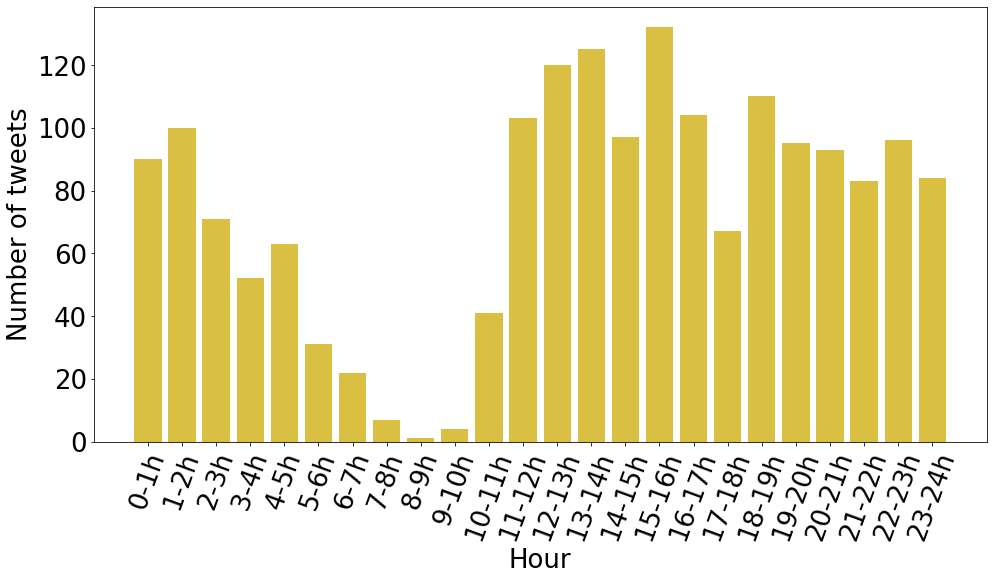

In [8]:
# Now let's see the number of tweets per hour
trump_tweets['time'] = [date.split()[1] for date in trump_tweets['date']]
trump_tweets['hour'] = [int(date.split(":")[0]) for date in trump_tweets['time']]
trump_tweets_hour = trump_tweets.groupby(['hour'])
nb_tweets_per_hour = [len(trump_tweets_hour.groups[i]) for i in range(0,24)]
label_for_xticks = ["{0}-{1}h".format(i,i+1) for i in range(0,24)]


#Plot
plt.subplots(figsize =(16, 8))
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.xticks(range(len(label_for_xticks)), label_for_xticks,rotation = 70)
plt.ylabel("Number of tweets")
plt.xlabel("Hour")
plt.bar(range(0,24),nb_tweets_per_hour,linewidth=3,color='#D9C043')
plt.show()


We can see that trump is not tweeting much from 6 to 10 am and he is very active from noon.

# Step 3: Cleaning the Data


In [9]:
# for the rest of this project I will just used the column containg the tweets
tweets = trump_tweets['text']
print(tweets)

0       We are United in our effort to defeat the Invi...
1       Congratulations Allen, great job! https://t.co...
2       So we catch Obama &amp; Biden, not to even men...
3       The Radical Left Democrats, who totally contro...
4       I am in @AirForceOne_HQ flying to the Great St...
                              ...                        
1786    Thank you and congratulations to General Flynn...
1787    .@BrianKempGA and puppet @GeoffDuncanGA. Your ...
1788                    Or worse! https://t.co/a7zbQ4TSD7
1789    Governor Kemp (@BrianKempGA) is down 18 points...
1790    FOR COURAGE &amp; BRILLIANCE! https://t.co/mPM...
Name: text, Length: 1791, dtype: object


## Remove URL, Numbers and HTML code Inside Tweets

Trump tweets can contain URL for journal articles or videos that need to be removed for the analysis. The numbers should also be removed. 

Let's see an example of tweet that includes an URL:

In [10]:
print(tweets[1])

Congratulations Allen, great job! https://t.co/jjeUk1SwGm


Now let's remove the URLs using a regular expression

In [11]:
tweets_wo_url = tweets.apply(lambda tweet: re.split('https:\/\/.*', str(tweet))[0])
print(tweets_wo_url[1])

Congratulations Allen, great job! 


In [12]:
#We also need to remove the numbers and special characters of the tweets:
tweets_wo_url_no_number = tweets_wo_url.str.replace('\d+', '') #Remove number
tweets_wo_url_no_number = tweets_wo_url_no_number.str.replace('&amp', ' ')
print(tweets_wo_url_no_number)

0       We are United in our effort to defeat the Invi...
1                      Congratulations Allen, great job! 
2       So we catch Obama  ; Biden, not to even mentio...
3       The Radical Left Democrats, who totally contro...
4       I am in @AirForceOne_HQ flying to the Great St...
                              ...                        
1786    Thank you and congratulations to General Flynn...
1787    .@BrianKempGA and puppet @GeoffDuncanGA. Your ...
1788                                           Or worse! 
1789    Governor Kemp (@BrianKempGA) is down  points i...
1790                          FOR COURAGE  ; BRILLIANCE! 
Name: text, Length: 1791, dtype: object


## Lowercase 
 In order to count multiple times the same word (e.g. 'Words' and 'words'), every word one is put in lower case.

In [13]:
tweets_lower_case = tweets_wo_url_no_number.str.lower()
print(tweets_lower_case)

0       we are united in our effort to defeat the invi...
1                      congratulations allen, great job! 
2       so we catch obama  ; biden, not to even mentio...
3       the radical left democrats, who totally contro...
4       i am in @airforceone_hq flying to the great st...
                              ...                        
1786    thank you and congratulations to general flynn...
1787    .@briankempga and puppet @geoffduncanga. your ...
1788                                           or worse! 
1789    governor kemp (@briankempga) is down  points i...
1790                          for courage  ; brilliance! 
Name: text, Length: 1791, dtype: object


## Ponctuation removal
Here, we do not need the ponctuations.

In [14]:
tweets_no_ponctuations = tweets_lower_case.str.replace('[^\w\s]','')
print(tweets_no_ponctuations)

0       we are united in our effort to defeat the invi...
1                        congratulations allen great job 
2       so we catch obama   biden not to even mention ...
3       the radical left democrats who totally control...
4       i am in airforceone_hq flying to the great sta...
                              ...                        
1786    thank you and congratulations to general flynn...
1787    briankempga and puppet geoffduncanga your poll...
1788                                            or worse 
1789    governor kemp briankempga is down  points in a...
1790                            for courage   brilliance 
Name: text, Length: 1791, dtype: object


## Tokenization

The tokenization consist to segment the document of interest in individual words.

In [15]:
tweets_tokenized = tweets_no_ponctuations.apply(nltk.word_tokenize)
print(tweets_tokenized)

0       [we, are, united, in, our, effort, to, defeat,...
1                    [congratulations, allen, great, job]
2       [so, we, catch, obama, biden, not, to, even, m...
3       [the, radical, left, democrats, who, totally, ...
4       [i, am, in, airforceone_hq, flying, to, the, g...
                              ...                        
1786    [thank, you, and, congratulations, to, general...
1787    [briankempga, and, puppet, geoffduncanga, your...
1788                                          [or, worse]
1789    [governor, kemp, briankempga, is, down, points...
1790                           [for, courage, brilliance]
Name: text, Length: 1791, dtype: object


## Stopwords removal
Stopword such as "The" are not informative, therefore they need to be removed.

In [16]:
stop = stopwords.words('english')
tweets_tokenized_no_stopwords = tweets_tokenized.apply(lambda token: [item for item in token if item not in stop])
print(tweets_tokenized_no_stopwords)

0       [united, effort, defeat, invisible, china, vir...
1                    [congratulations, allen, great, job]
2       [catch, obama, biden, even, mention, rest, cre...
3       [radical, left, democrats, totally, control, b...
4       [airforceone_hq, flying, great, state, texas, ...
                              ...                        
1786    [thank, congratulations, general, flynn, incre...
1787    [briankempga, puppet, geoffduncanga, poll, num...
1788                                              [worse]
1789    [governor, kemp, briankempga, points, recent, ...
1790                                [courage, brilliance]
Name: text, Length: 1791, dtype: object


## Lemmatization

Lemmatization allows to find the root of the word.

In [17]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in text]

tweets_tokenized_no_stopwords_stemmed_lemmatized = tweets_tokenized_no_stopwords.apply(lemmatize_text)

print(tweets_tokenized_no_stopwords_stemmed_lemmatized)

0       [united, effort, defeat, invisible, china, vir...
1                     [congratulation, allen, great, job]
2       [catch, obama, biden, even, mention, rest, cre...
3       [radical, left, democrat, totally, control, bi...
4       [airforceone_hq, fly, great, state, texas, ama...
                              ...                        
1786    [thank, congratulation, general, flynn, incred...
1787    [briankempga, puppet, geoffduncanga, poll, num...
1788                                                [bad]
1789    [governor, kemp, briankempga, point, recent, p...
1790                                [courage, brilliance]
Name: text, Length: 1791, dtype: object


# Step 4: Topic Modelling using Term Frequency-Inverse Document Frequency (TF-IDF)

In [18]:
all_tweets_words = [] #initialize a list which will contain all words. (WordCloud)
all_tweets = [] #initialize a list which will contain all tweets. Each element in the list will be a tweet (tf-idf)

for tweet_sentence in tweets_tokenized_no_stopwords_stemmed_lemmatized:
    all_tweets.append(" ".join(tweet_sentence))
    for tweet_word in tweet_sentence:
        all_tweets_words.append(tweet_word.capitalize())

### Let's start with a world cloud

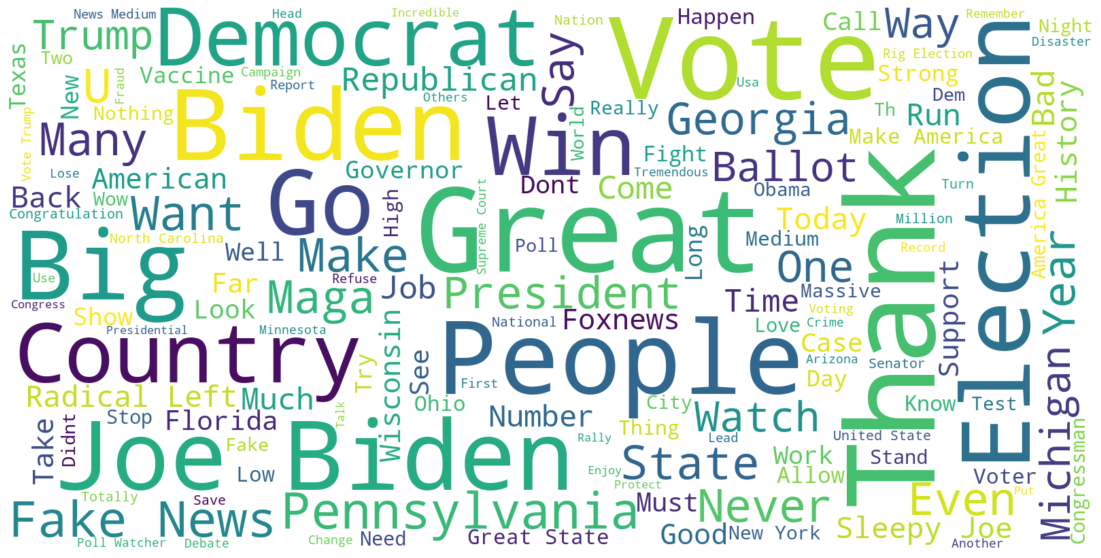

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=180, max_words=150,background_color="white").generate(" ".join(all_tweets_words))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("trump_tweets_wordclourd.tif",dpi=300)
plt.show()

### Topic modelling using TF-IDF

In [20]:
vectorizer = TfidfVectorizer(norm = None)
tfidf_scores = vectorizer.fit_transform(all_tweets)
feature_names = vectorizer.get_feature_names()
tfidf_scores = vectorizer.fit_transform(all_tweets)
nmf = NMF(n_components=5, random_state=1,max_iter=400).fit(tfidf_scores)


for topic_idx, topic in enumerate(nmf.components_):
    topic_elements = [feature_names[i]for i in topic.argsort()[:-10 - 1:-1]]
    print("Topic #{0}: {1}".format(topic_idx,topic_elements))


Topic #0: ['great', 'people', 'thank', 'make', 'state', 'america', 'job', 'go', 'one', 'new']
Topic #1: ['biden', 'joe', 'sleepy', 'would', 'want', 'left', 'radical', 'american', 'year', 'corrupt']
Topic #2: ['fake', 'news', 'covid', 'medium', 'test', 'talk', 'case', 'lamestream', 'people', 'report']
Topic #3: ['vote', 'trump', 'election', 'today', 'watcher', 'get', 'poll', 'pennsylvania', 'voting', 'day']
Topic #4: ['big', 'win', 'see', 'get', 'democrat', 'florida', 'georgia', 'usdot', 'drug', 'crowd']


Based on my small knowledge on Trump's favorite topics, I recast the topics as:

- Topic #0: Make america great again
- Topic #1: Sleepy Joe and the radical left
- Topic #2: Fake news and lamestream media
- Topic #3: Election and poll
- Topic #3: Big win

These topics are in agreement with the american elections.